In [196]:
# import required packages
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras.layers import Dropout
from keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

import seaborn as sns
from scipy import stats
from keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import SimpleRNN,Dense,Activation, LSTM


## Function to calulate sensitivity and specificity

In [197]:
# Define a function to calculate sensitivity and specificity for each class from a confusion matrix:


def calculate_metrics_per_class(confusion_matrix):
    """
    Calculate sensitivity and specificity for each class from a confusion matrix.

    Parameters:
    - confusion_matrix: numpy array, shape (n_classes, n_classes)
        The confusion matrix.

    Returns:
    - sensitivities: numpy array, shape (n_classes,)
        Sensitivity (True Positive Rate or Recall) for each class.
    - specificities: numpy array, shape (n_classes,)
        Specificity (True Negative Rate) for each class.
    """
    n_classes = confusion_matrix.shape[0]
    sensitivities = np.zeros(n_classes)
    specificities = np.zeros(n_classes)

    for i in range(n_classes):
        true_positive = confusion_matrix[i, i]
        false_negative = np.sum(confusion_matrix[i, :]) - true_positive
        false_positive = np.sum(confusion_matrix[:, i]) - true_positive
        true_negative = np.sum(confusion_matrix) - (true_positive + false_negative + false_positive)

        # Sensitivity (True Positive Rate or Recall) for each class
        sensitivities[i] = true_positive / (true_positive + false_negative)

        # Specificity (True Negative Rate) for each class
        specificities[i] = true_negative / (true_negative + false_positive)

    return sensitivities, specificities

## Loading the data

In [198]:
battery_df = pd.read_csv("Battery_RUL.csv")
battery_copy_df = battery_df.copy()
battery_copy_df

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107
...,...,...,...,...,...,...,...,...,...
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1


## Data Preprocessing and Cleaning

In [199]:

battery_copy_df = battery_copy_df.dropna()  # Remove NA cells if present


### Adding Battery ID column

In [200]:
# Initialize the battery ID variable
battery_id = 1
battery_ids = []

# Initialize a flag to track when to increment the battery ID
start_new_battery = True

# Loop through the DataFrame
for rul in battery_copy_df['RUL']:
    if start_new_battery:
        # Start a new battery ID
        battery_ids.append(battery_id)
        start_new_battery = False  # Reset flag
    else:
        # Continue with the current battery ID
        battery_ids.append(battery_id)
        
    if rul == 0:
        start_new_battery = True  # Set flag to start a new battery on next iteration
        battery_id += 1  # Increment battery ID after reaching RUL of 0

# Create a new DataFrame for Battery ID
battery_id_df = pd.DataFrame(battery_ids, columns=['Battery ID'])

# Concatenate Battery ID DataFrame with the original data
# Make sure to reset the index to align both DataFrames correctly if they aren't aligned
battery_copy_df.reset_index(drop=True, inplace=True)
battery_id_df.reset_index(drop=True, inplace=True)
battery_copy_df = pd.concat([battery_id_df, battery_copy_df], axis=1)

battery_copy_df

,Battery ID,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,1,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,1,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,1,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107
...,...,...,...,...,...,...,...,...,...,...
15059,14,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,14,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,14,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
15062,14,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1


### Drop the Cycle index as it is not useful 

In [201]:
battery_copy_df = battery_copy_df.drop(['Cycle_Index'],axis=1)
battery_copy_df.columns

Index(['Battery ID', 'Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
       'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)',
       'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)',
       'RUL'],
      dtype='object')

### Split the data to test and train

##### The test data is a randomly selected 4 batteries

In [202]:
# Get unique battery IDs and split them
unique_battery_ids = battery_copy_df['Battery ID'].unique()
train_ids, test_ids = train_test_split(unique_battery_ids, test_size=4, random_state=42)  # Randomly select 4 IDs for testing

# Split the data into train and test based on the selected IDs
train_data = battery_copy_df[battery_copy_df['Battery ID'].isin(train_ids)]
test_data = battery_copy_df[battery_copy_df['Battery ID'].isin(test_ids)]


### Standardize the data

In [203]:
train_df = pd.DataFrame(train_data)
# Columns to scale
columns_to_scale = [
    'Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)',
    'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)'
]

# Standardize the selected columns
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(train_df[columns_to_scale])
scaled_columns = pd.DataFrame(scaled_data_train, columns=columns_to_scale, index=train_df.index)

# Select non-scaled columns
non_scaled_columns = train_df[['Battery ID', 'RUL']]

# Concatenate scaled and non-scaled columns
scaled_df_train = pd.concat([non_scaled_columns, scaled_columns], axis=1)

# Display the scaled DataFrame and check for NaN values
scaled_df_train

,Battery ID,RUL,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s)
1076,2,1107,-0.060300,-0.004832,-2.599965,-2.942101,0.178755,0.047295
1077,2,1106,0.082844,-0.001935,3.642054,-2.877732,0.185579,0.048113
1078,2,1105,0.082216,-0.006279,3.663727,-2.845547,0.184820,0.047840
1079,2,1104,0.082006,-0.007968,3.685401,-2.829455,0.184824,0.047840
1080,2,1102,1.807089,-0.007810,4.140548,-1.525971,0.182547,1.861258
...,...,...,...,...,...,...,...,...
15059,14,4,-0.115197,-0.074295,-1.440423,1.314338,-0.308822,-0.159086
15060,14,3,-0.115176,-0.074295,-1.440423,1.330430,-0.309608,-0.159089
15061,14,2,-0.115236,-0.074306,-1.440423,1.314338,-0.309608,-0.159089
15062,14,1,-0.115094,-0.075478,-1.548792,2.094819,-0.350343,-0.169393


In [204]:
test_df = pd.DataFrame(test_data)
# Columns to scale
columns_to_scale = [
    'Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)',
    'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)'
]

# Standardize the selected columns
scaler = StandardScaler()
scaled_data_test = scaler.fit_transform(test_df[columns_to_scale])
scaled_columns = pd.DataFrame(scaled_data_test, columns=columns_to_scale, index=test_df.index)

# Select non-scaled columns
non_scaled_columns = test_df[['Battery ID', 'RUL']]

# Concatenate scaled and non-scaled columns
scaled_df_test = pd.concat([non_scaled_columns, scaled_columns], axis=1)

# Display the scaled DataFrame and check for NaN values
scaled_df_test

,Battery ID,RUL,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s)
0,1,1112,-0.058297,-0.002844,-2.787437,-2.987711,0.192590,0.057506
1,1,1111,0.089845,-0.001555,3.797615,-2.914049,0.198118,0.057800
2,1,1110,0.089387,-0.005203,3.831912,-2.881310,0.198118,0.057800
3,1,1109,0.089132,-0.007206,3.843344,-2.873125,0.197331,0.057800
4,1,1107,1.863056,1.753761,4.300640,-1.457172,0.194959,2.003580
...,...,...,...,...,...,...,...,...
14008,13,4,-0.110272,-0.059094,-1.404119,0.998239,-0.284958,-0.149703
14009,13,3,-0.110309,-0.059094,-1.404119,0.998239,-0.285458,-0.149700
14010,13,2,-0.137116,-0.071043,-8.960924,0.531711,-0.411286,-0.225115
14011,13,1,-0.110224,-0.059558,-1.507011,1.882187,-0.314465,-0.155368


### Re-format training data into (samples, time steps, features) form

In [205]:
# define utility function
def generate_LSTM_samples(battery_df, nSequenceSteps):
    #This function generates list of LSTM samples (numpy arrays of size (nSequenceSteps, 19) each) for LSTM input
    #and list of output labels for LSTM (19 columns)
    battery_X_train_sequence = []
    battery_y_train_sequence = []
    battery_data = battery_df.values # converting to numpy
    
    for sample in range(nSequenceSteps, battery_data.shape[0]):
        battery_X_train_sequence.append(battery_data[sample-nSequenceSteps:sample,:-1]) 
        battery_y_train_sequence.append(battery_data[sample,-1])
    
    return battery_X_train_sequence, battery_y_train_sequence

In [206]:
nSequenceSteps = 50 # number of cycles in a sequence
X_train_sequence = []
y_train_sequence = []

# generate samples
for batteryID in train_data['Battery ID'].unique():
    battery_df = train_data[train_data['Battery ID'] == batteryID]
    battery_df = train_data[['Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
       'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)',
       'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)',
       'RUL']]
    battery_X_train_sequence, battery_y_train_sequence = generate_LSTM_samples(battery_df, nSequenceSteps)
    
    X_train_sequence = X_train_sequence + battery_X_train_sequence # adding samples to the common list
    y_train_sequence = y_train_sequence + battery_y_train_sequence

X_train_sequence, y_train_sequence = np.array(X_train_sequence), np.array(y_train_sequence) 

## Building The Network

In [207]:
# Define model 
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(nSequenceSteps, 7)))
model.add(LSTM(units=40, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=30))
model.add(Dense(20, kernel_regularizer=regularizers.L2(1e-4), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.L2(1e-4), activation='relu'))
model.add(Dense(1))

In [208]:
# print the network and its layers 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50, 60)            16320     
_________________________________________________________________
lstm_10 (LSTM)               (None, 50, 40)            16160     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30)                8520      
_________________________________________________________________
dense_9 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [209]:
# compile the model
model.compile(loss='mae', optimizer=Adam(learning_rate=0.005), metrics=['mae'])

## Fitting the network

In [210]:
# fit model with early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)
history = model.fit(X_train_sequence, y_train_sequence, epochs=60, batch_size=64, validation_split=0.3, callbacks=[es])

Epoch 1/60
1172/1172 [==============================] - 60s 49ms/step - loss: 284.1523 - mae: 284.1377 - val_loss: 69.5304 - val_mae: 69.5070
Epoch 2/60
1172/1172 [==============================] - 58s 49ms/step - loss: 66.9511 - mae: 66.9268 - val_loss: 58.9560 - val_mae: 58.9316
Epoch 3/60
1172/1172 [==============================] - 60s 51ms/step - loss: 56.0666 - mae: 56.0423 - val_loss: 54.7373 - val_mae: 54.7132
Epoch 4/60
1172/1172 [==============================] - 61s 52ms/step - loss: 51.0760 - mae: 51.0518 - val_loss: 58.3248 - val_mae: 58.3004
Epoch 5/60
1172/1172 [==============================] - 60s 51ms/step - loss: 47.4261 - mae: 47.4018 - val_loss: 38.2920 - val_mae: 38.2676
Epoch 6/60
1172/1172 [==============================] - 61s 52ms/step - loss: 40.4246 - mae: 40.4002 - val_loss: 36.9141 - val_mae: 36.8897
Epoch 7/60
1172/1172 [==============================] - 61s 52ms/step - loss: 38.5406 - mae: 38.5162 - val_loss: 34.9001 - val_mae: 34.8755
Epoch 8/60
1172/11

## Save the model

In [132]:
model.save('Battery_Reg1')

INFO:tensorflow:Assets written to: Battery_Reg1\assets


INFO:tensorflow:Assets written to: Battery_Reg1\assets


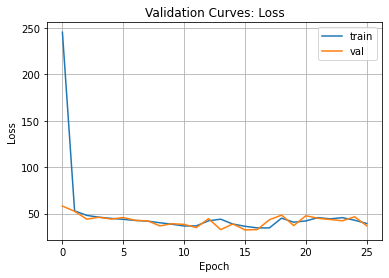

In [133]:
# plot validation curve
plt.figure()
plt.title('Validation Curves: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Specify the engine ID you want to analyze
selected_batteryID = battery_copy_df[battery_copy_df['Battery ID'].isin(np.random(test_ids))]

# Get data for the selected engine
Battery_data = scaled_df_test[scaled_df_test['Battery ID'] == selected_batteryID]

# Prepare sequences over the engine's lifetime
sequences = []
X_test_sequence = []
y_test_sequence = []
for i in range(len(Battery_data) - nSequenceSteps + 1):
    sequence = Battery_data.iloc[i : i + nSequenceSteps][['Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
       'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)',
       'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)',
       'RUL']].values
    X_test_sequence.append(sequence[:,:-1])
    y_test_sequence.append(sequence[-1,-1])

# Convert sequences to numpy array
X_test_sequence, y_test_sequence = np.array(X_test_sequence), np.array(y_test_sequence)


# Predict RUL for the sequences
y_test_sequence_pred = model.predict(X_test_sequence)

# Plot the predicted and actual RUL over time
plt.figure()
plt.plot(y_test_sequence_pred, color="blue", label='prediction')
plt.plot(y_test_sequence, color="green", label='actual')
plt.title(f'LSTM Model Prediction vs Actual RUL for Battery ID {selected_batteryID}')
plt.ylabel('RUL')
plt.xlabel('Index')
plt.legend(loc='upper left')
plt.grid()
plt.show()
